<a href="https://colab.research.google.com/github/ngkarthi71/colon-cancer-analysis/blob/final-_task-_one/Final_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading the given Data Set

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/'My Drive'/CML-Assignment2/

cell_model_VGG_3   Image_classification_data.zip
Final_Task1.ipynb  latest.ipynb


In [4]:
!cp /content/drive/'My Drive'/CML-Assignment2/Image_classification_data.zip .
!unzip -q -o Image_classification_data.zip
!rm Image_classification_data.zip
!ls

data_labels_extraData.csv  drive     patch_images
data_labels_mainData.csv   __MACOSX  sample_data


# Importing the needed Packages

In [5]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2 as cv

import IPython.display as display
from PIL import Image
from sklearn.model_selection import GridSearchCV

from skimage.transform import resize
from skimage.io import imread
import warnings;
warnings.simplefilter('ignore')


# Loading the Data set 

In [6]:
cancer=pd.read_csv('data_labels_mainData.csv')

In [7]:
cancer.head(5)

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


# Data Exploration

In [8]:
cancer.dtypes

InstanceID       int64
patientID        int64
ImageName       object
cellTypeName    object
cellType         int64
isCancerous      int64
dtype: object

In [9]:
cancer.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [11]:
cancer.isCancerous.value_counts()

0    5817
1    4079
Name: isCancerous, dtype: int64

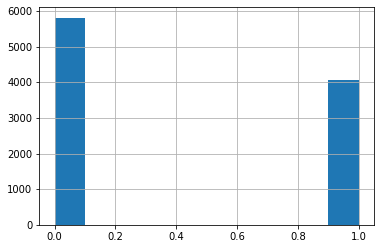

In [12]:
cancer.isCancerous.hist()
plt.show()

Text(0, 0.5, 'notCancerous samples')

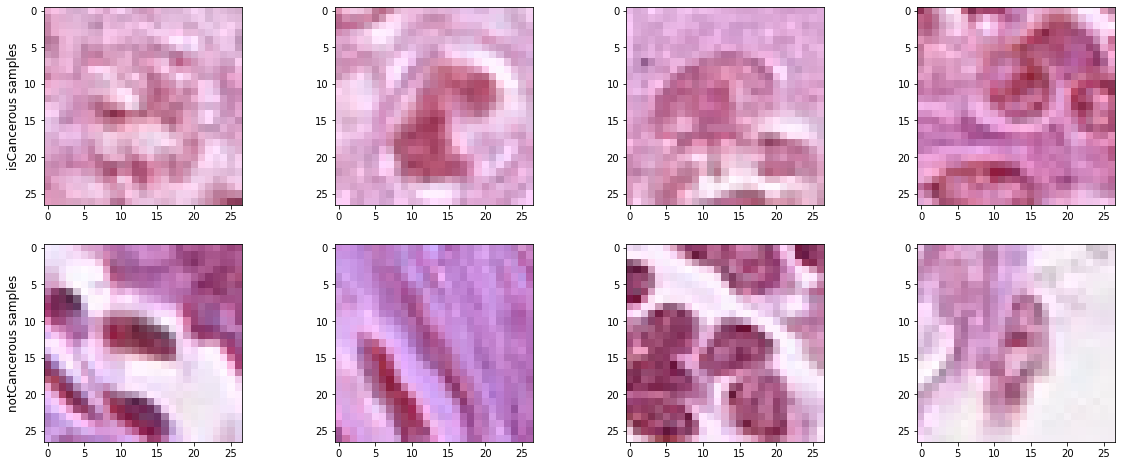

In [13]:
isCancerous = cancer.loc[cancer['isCancerous'] == 1].sample(4)
notCancerous = cancer.loc[cancer['isCancerous'] == 0].sample(4)

isCancerous_images = []
notCancerous_images = []

for path in isCancerous['ImageName']:
    image_path = "/content/patch_images/" + path
    image = cv.imread(image_path)
    isCancerous_images.append(image)
    
for path in notCancerous['ImageName']:
    image_path = "/content/patch_images/" + path
    image = cv.imread(image_path)
    notCancerous_images.append(image)

fig,axis = plt.subplots(2,4,figsize=(20,8))
for i, image in enumerate(isCancerous_images):
    axis[0,i].imshow(image)
axis[0,0].set_ylabel('isCancerous samples', size='large')

for i, image in enumerate(notCancerous_images):
    axis[1,i].imshow(image)
axis[1,0].set_ylabel('notCancerous samples', size='large')

## Stochastic Gradient Descent model - Traditional machine learning algorithm

Data Reshaping :flattening images into image array in order to proceed with the algorithm

In [14]:
flat_data_arr=[]
target_arr=[]

for img in cancer['ImageName']:
    path = "/content/patch_images/" + img
    image_arr = cv.imread(path)
    #print(image_arr)
    img_resized=resize(image_arr,(27, 27, 3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(cancer.loc[cancer['ImageName'] == img].isCancerous)
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data_arr)
df['Target']=target
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2148,2149,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159,2160,2161,2162,2163,2164,2165,2166,2167,2168,2169,2170,2171,2172,2173,2174,2175,2176,2177,2178,2179,2180,2181,2182,2183,2184,2185,2186,Target
0,0.929412,0.835294,0.949020,0.913725,0.819608,0.937255,0.898039,0.803922,0.921569,0.890196,0.792157,0.913725,0.929412,0.827451,0.949020,0.945098,0.839216,0.960784,0.941176,0.831373,0.956863,0.925490,0.811765,0.941176,0.905882,0.784314,0.917647,0.886275,0.764706,0.894118,0.858824,0.733333,0.870588,0.858824,0.737255,0.874510,0.854902,0.733333,0.874510,0.854902,...,0.803922,0.647059,0.843137,0.847059,0.690196,0.886275,0.909804,0.749020,0.937255,0.925490,0.760784,0.949020,0.909804,0.745098,0.933333,0.921569,0.756863,0.949020,0.945098,0.780392,0.972549,0.941176,0.776471,0.972549,0.913725,0.745098,0.941176,0.874510,0.705882,0.901961,0.760784,0.592157,0.788235,0.686275,0.517647,0.709804,0.745098,0.576471,0.764706,0
1,0.827451,0.686275,0.866667,0.827451,0.686275,0.878431,0.858824,0.721569,0.913725,0.854902,0.717647,0.901961,0.921569,0.784314,0.964706,1.000000,0.858824,1.000000,0.925490,0.776471,0.949020,0.894118,0.733333,0.905882,0.847059,0.682353,0.854902,0.874510,0.705882,0.874510,0.890196,0.733333,0.890196,0.870588,0.729412,0.878431,0.803922,0.682353,0.815686,0.850980,...,0.898039,0.784314,0.984314,0.925490,0.811765,0.992157,0.901961,0.811765,0.984314,0.866667,0.796078,0.960784,0.894118,0.819608,0.976471,0.945098,0.866667,1.000000,0.972549,0.886275,1.000000,0.949020,0.858824,0.980392,0.921569,0.831373,0.952941,0.937255,0.843137,0.968627,0.905882,0.811765,0.941176,0.933333,0.835294,0.968627,0.956863,0.858824,0.992157,0
2,0.968627,0.952941,0.968627,0.964706,0.949020,0.972549,0.956863,0.937255,0.968627,0.945098,0.917647,0.960784,0.949020,0.909804,0.960784,0.952941,0.894118,0.956863,0.933333,0.858824,0.933333,0.905882,0.815686,0.898039,0.854902,0.737255,0.835294,0.827451,0.686275,0.796078,0.815686,0.650980,0.772549,0.807843,0.623529,0.756863,0.776471,0.584314,0.725490,0.772549,...,0.713725,0.462745,0.647059,0.705882,0.435294,0.627451,0.721569,0.443137,0.639216,0.717647,0.431373,0.631373,0.705882,0.415686,0.619608,0.682353,0.384314,0.592157,0.584314,0.290196,0.498039,0.619608,0.325490,0.537255,0.643137,0.356863,0.568627,0.619608,0.341176,0.552941,0.686275,0.419608,0.635294,0.784314,0.529412,0.745098,0.764706,0.529412,0.745098,0
3,0.949020,0.949020,0.952941,0.945098,0.945098,0.952941,0.945098,0.945098,0.952941,0.949020,0.949020,0.952941,0.952941,0.949020,0.952941,0.956863,0.952941,0.956863,0.956863,0.952941,0.956863,0.956863,0.952941,0.956863,0.952941,0.949020,0.952941,0.952941,0.945098,0.952941,0.952941,0.945098,0.952941,0.956863,0.945098,0.952941,0.956863,0.945098,0.952941,0.960784,...,0.909804,0.858824,0.933333,0.886275,0.831373,0.909804,0.913725,0.858824,0.937255,0.956863,0.898039,0.976471,0.949020,0.890196,0.972549,0.937255,0.866667,0.952941,0.913725,0.831373,0.929412,0.945098,0.850980,0.952941,0.960784,0.850980,0.960784,0.949020,0.827451,0.945098,0.956863,0.827451,0.949020,0.988235,0.854902,0.972549,0.866667,0.729412,0.847059,0
4,0.741176,0.509804,0.741176,0.721569,0.494118,0.729412,0.717647,0.494118,0.733333,0.729412,0.509804,0.745098,0.776471,0.568627,0.792157,0.784314,0.603922,0.811765,0.788235,0.627451,0.823529,0.756863,0.580392,0.788235,0.662745,0.458824,0.686275,0.721569,0.501961,0.713725,0.874510,0.650980,0.839216,0.850980,0.627451,0.803922,0.878431,0.650980,0.835294,0.858824,...,0.960784,0.929412,0.964706,0.976471,0.952941,0.984314,0.972549,0.949020,0.976471,0.964706,0.945098,0.972549,0.952941,0.933333,0.960784,0.952941,0.933333,0.960784,0.949020,0.937255,0.956863,0.941176,0.937255,0.952941,0.937255,0.933333,0.949020,0.941176,0.937255,0.952941,0.945098,0.937255,0.952941,0.949020,0.937255,0.956863,0.956863,0.941176,0.956863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

## Test -Train split

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)

## Building an image classfier model using SGDClassifier

In [17]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(loss='hinge', random_state=42)
sgd_clf.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring='accuracy')

array([0.71504358, 0.84350133, 0.85633055])

In [19]:
score = sgd_clf.score(x_test, y_test)
score

0.8570707070707071

## Fine tuning the model in order to get better accuracy

In [20]:
sgd_clf = SGDClassifier(loss='log', random_state=42, 
                        penalty='l2', alpha=1e-4)
sgd_clf.fit(x_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [21]:
cross_val_score(sgd_clf, x_train, y_train, cv=7, scoring='accuracy')

array([0.84969054, 0.74889478, 0.78868258, 0.84261715, 0.84350133,
       0.85057471, 0.83362832])

In [22]:
score = sgd_clf.score(x_test, y_test)
score

0.7141414141414142

# Classic Neural Network Model

### Randomly split the given data set

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train_data, test_data = train_test_split(cancer, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


# Model development

In [25]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [2]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.5.0'

In [28]:


model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 560,642
Trainable params: 560,642
Non-trainable params: 0
_________________________________________________________________


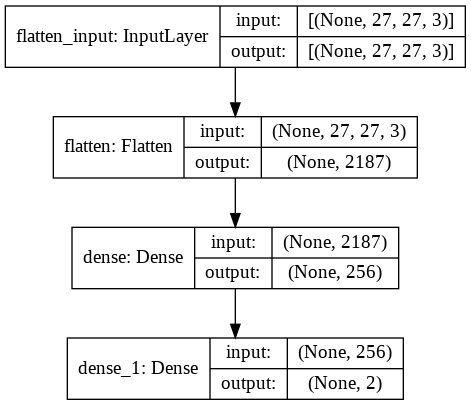

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [32]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [33]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [34]:
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=150,verbose=0)

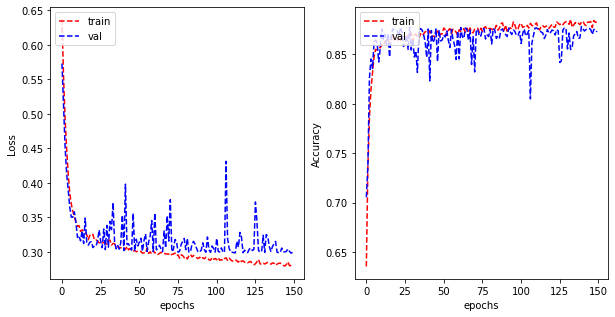

In [35]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [36]:
model.save("detect_cancer")

INFO:tensorflow:Assets written to: detect_cancer/assets


# Evaluating the Trained Model

In [38]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')
batch_size = 1

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Found 1980 validated image filenames belonging to 2 classes.
Accuracy score:  0.8782828282828283
F1 score:  0.8744717372003552
[[1042  147]
 [  94  697]]


In [39]:
model.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.3063 - categorical_accuracy: 0.8783


[0.306303471326828, 0.8782828450202942]

In [40]:
label_names = {'cancer' : 0, 'noCancer' : 1}

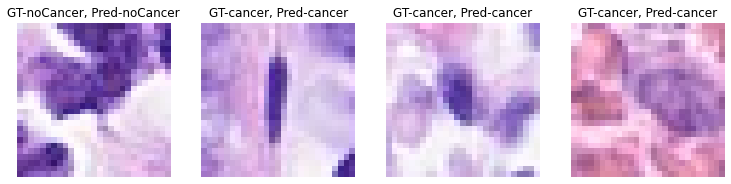

In [41]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# VGG Model- Predicting cell image whether cancerous or not

In [42]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27,27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [43]:


model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [45]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [46]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25,verbose=0)

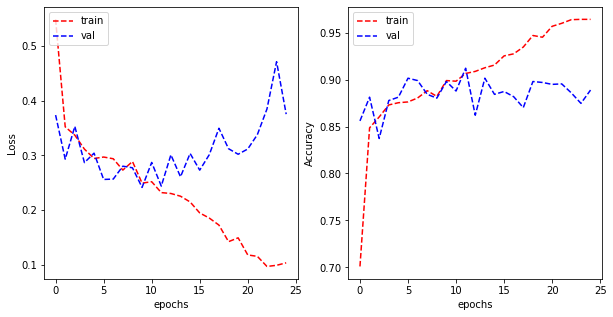

In [47]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Overfitting

## Apply Regularisation

In [48]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [49]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

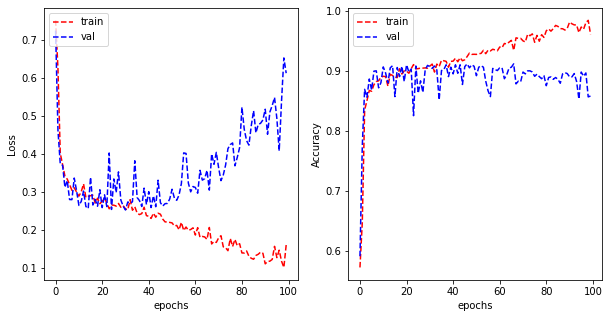

In [50]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Data Augmentation

In [ ]:

train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.2,
                                   height_shift_range=0.2, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

In [3]:
reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [5]:
model_VGG_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 128)         7

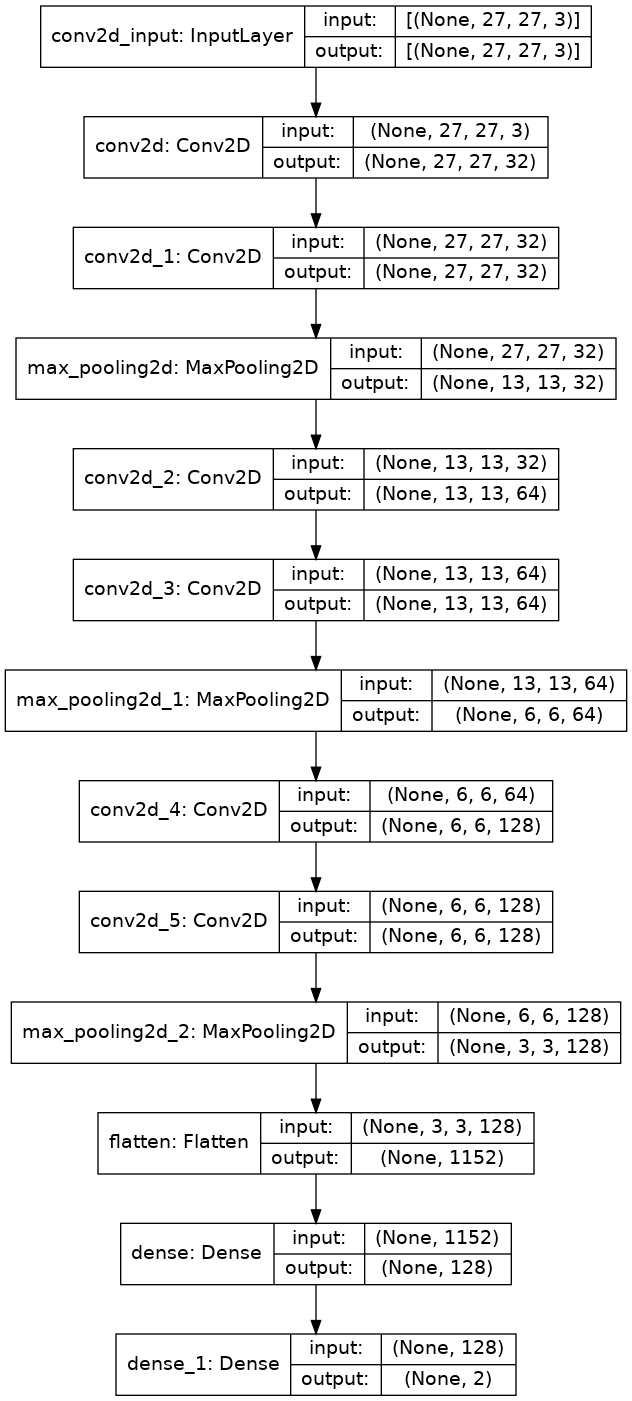

In [6]:
tf.keras.utils.plot_model(model_VGG_3, show_shapes=True)

In [53]:
model_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

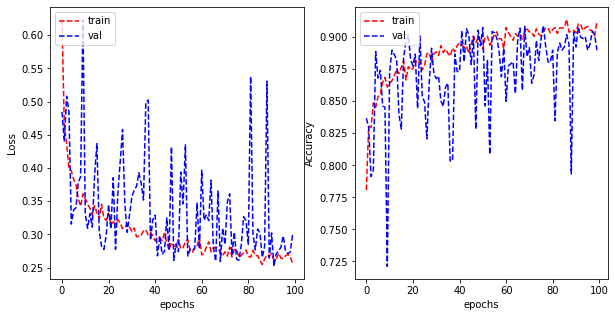

In [54]:
history_VGG_3 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['categorical_accuracy'], history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Save the Model



In [55]:
model_VGG_3.save("model_VGG_3")

INFO:tensorflow:Assets written to: model_VGG_3/assets


In [56]:
!cp -R ./model_VGG_3 /content/drive/'My Drive'/CML-Assignment2/

## Testing the Model we have created finally

In [58]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')
batch_size = 1
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')



test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='/content/patch_images',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_VGG_3.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break

# now you have made the predictions you can use any performance metric
# you wish: either in sklearn or some function you have written

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))

Found 1980 validated image filenames belonging to 2 classes.
Accuracy score:  0.8808080808080808
F1 score:  0.8744371868856617
[[1095   94]
 [ 142  649]]


In [59]:
model_VGG_3.evaluate(test_generator)

1980/1980 [==============================] - 6s 3ms/step - loss: 0.3192 - categorical_accuracy: 0.8808


[0.3191906213760376, 0.8808080554008484]

## Plotting our Final Results

In [60]:
label_names = {'cancer' : 0, 'noCancer' : 1}

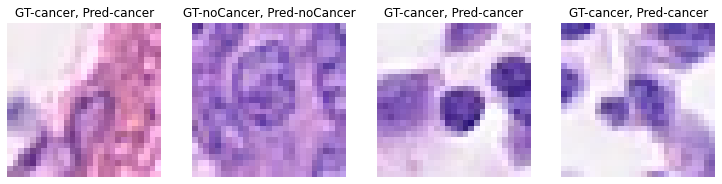

In [61]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_VGG_3.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')